In [1]:
import numpy as np
import time

In [2]:

import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.optimization import get_neab
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
from neuronunit.optimization import model_parameters as modelp

from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq





mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vPeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100
mparams['dt'] = 0.025
mparams['tMax'] = 1000.0;#   % max time [ms]
#mparams['tMax'] = 1000.0;#   % max time [ms]
from neuronunit.optimization.data_transport_container import DataTC



# compile and discard a model, to initialize the JIT
and discard, this is to purge a space and make model speed comparison fair.


In [3]:
model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 10*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0# 100.0*pq.ms
DURATION = 520*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)
model = None

# Vanilla parameters model to model check (succeeds).
# RAW is significantly faster

2
3
5
7
mean simulation time: 0.001530468463897705. Total time: 0.00612187385559082


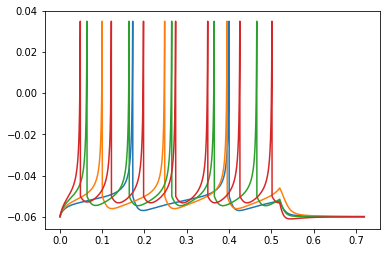

In [4]:
times = []

for current in [60,70,85,100]:
    # compile a model and discard

    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(mparams)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0# 100.0*pq.ms
    DURATION = 520*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.results['vm'].times,model.results['vm'])
    
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))

2
0.8641645908355713 simulation
3
0.48003435134887695 simulation
5
0.4581892490386963 simulation
7
0.4161648750305176 simulation
mean simulation time: 0.5546382665634155. Total time: 2.218553066253662


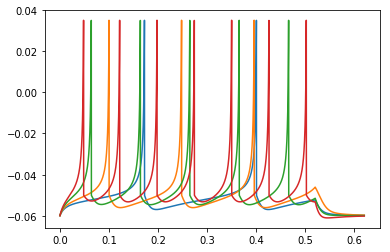

In [5]:
times = []
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
#model.set_attrs(mparams)
for current in [60,70,85,100]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0# 100.0*pq.ms
    DURATION = 520
    iparams['injected_square_current']['delay'] = DELAY*pq.ms
    iparams['injected_square_current']['duration'] = DURATION*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))

NEURON units                                           NeuroML units   

v0 = -60 (mV),  vr = -60 (mV) ,                        mparams['vr'] = -60

k = 7.0E-4 (uS / mV),                                  mparams['k'] = 0.7                ***different

vt = -40 (mV)

vpeak = 35 (mV)                 mparams['vPeak'] = 35

a = 0.030000001 (kHz) [ms-1],   mparams['a'] = 0.03

b = -0.002 (uS),                mparams['b'] = -2

c = -50 (mV),                   mparams['c'] = -50  

d = 0.1 (nA) --MATLAB pA        mparams['d'] = 100  ******** pA

C = 1.0E-4 (microfarads)        mparams['C'] = 100 ******** co faraday)

In [6]:
import collections
# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    #FS[k] = v[4]
    RTN_burst[k] = v[-2]
    
RTN_burstN = copy.copy(RTN_burst)
TCN = copy.copy(TC)
IBN = copy.copy(IB)
CHN = copy.copy(CH)


# translate from NeuroML's pico to NEURONs nano
#for k in 'd', 'k':
RTN_burstN['d'] = RTN_burst['d']/1000.0
IBN['d'] = IB['d']/1000.0
CHN['d'] = CH['d']/1000.0    
TCN['d'] = TC['d']/1000.0

RTN_burstN['k'] = RTN_burst['k']/1000.0
IBN['k'] = IB['k']/1000.0
CHN['k'] = CH['k']/1000.0    
TCN['k'] = TC['k']/1000.0

RTN_burstN['C'] = RTN_burst['C']/1000000.0
IBN['C'] = IB['C']/1000000.0
CHN['C'] = CH['C']/1000000.0    
TCN['C'] = TC['C']/1000000.0

 
#for k in 'd', 'k':
RTN_burstN['b'] = RTN_burst['b']/1000.0
IBN['b'] = IB['b']/1000.0
CHN['b'] = CH['b']/1000.0    
TCN['b'] = TC['b']/1000.0


    
    #list_of_params_dics = [] 

def translate(input_dic):
    input_dic['vpeak'] = input_dic['vPeak']
    input_dic.pop('vPeak', None)     
    input_dic.pop('dt', None)        

    return input_dic
IBN = translate(IBN)
CHN = translate(CHN)
TCN = translate(TCN)
print(CHN)

{'k': 0.0015, 'C': 5e-05, 'vpeak': 25, 'vt': -40, 'c': -40, 'b': 0.001, 'a': 0.03, 'd': 0.15, 'vr': -60}


The following cells follow the Backend pattern RAW, NEURON, RAW, NEURON.

0
0.0010156631469726562 simulation
1
0.0007634162902832031 simulation
3
0.0007264614105224609 simulation
5
0.0007488727569580078 simulation
mean simulation time: 0.000813603401184082. Total time: 0.003254413604736328


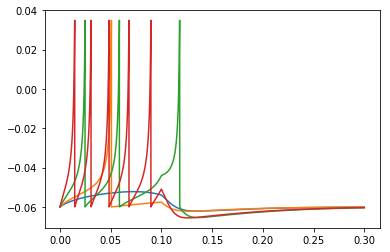

In [7]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))


model.set_attrs(TC)
#print(FS)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    


{'k': 0.0016, 'C': 0.0002, 'vpeak': 35, 'vt': -50, 'c': -60, 'b': 0.015, 'a': 0.01, 'd': 0.01, 'vr': -60}
1
0.1463475227355957 simulation
{'k': 0.0016, 'C': 0.0002, 'vpeak': 35, 'vt': -50, 'c': -60, 'b': 0.015, 'a': 0.01, 'd': 0.01, 'vr': -60}
2
0.1545414924621582 simulation
{'k': 0.0016, 'C': 0.0002, 'vpeak': 35, 'vt': -50, 'c': -60, 'b': 0.015, 'a': 0.01, 'd': 0.01, 'vr': -60}
5
0.15062594413757324 simulation
{'k': 0.0016, 'C': 0.0002, 'vpeak': 35, 'vt': -50, 'c': -60, 'b': 0.015, 'a': 0.01, 'd': 0.01, 'vr': -60}
10
0.15169191360473633 simulation
mean simulation time: 0.15080171823501587. Total time: 0.6032068729400635
{'k': 1.6, 'C': 200, 'a': 0.01, 'vt': -50, 'c': -60, 'vr': -60, 'd': 10, 'vPeak': 35, 'b': 15}


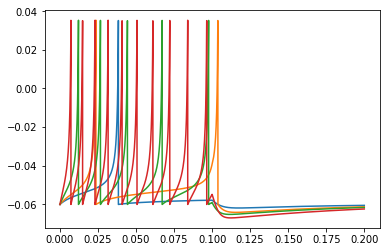

In [8]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]


times = []
for current in IinRange:
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    #for k in 'k','d','C':
    #    TCN[k] = TC[k]/1000.0
    model.set_attrs(TCN)
    print(TCN)

    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']

    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))   
#plt.plot(model.results['vm'].times,model.results['vm'])
    
print(TC)

In [9]:
  # CH
tstop = 210
IinRange = [200,300,400,600]

{'k': 0.25, 'C': 40, 'a': 0.015, 'vt': -45, 'c': -55, 'vr': -65, 'd': 50, 'vPeak': 0, 'b': 10}
{'k': 0.25, 'C': 40, 'a': 0.015, 'vt': -45, 'c': -55, 'vr': -65, 'd': 50, 'vPeak': 0, 'b': 10}
0
0.0016677379608154297 simulation
0
0.0016658306121826172 simulation
0
0.0016894340515136719 simulation


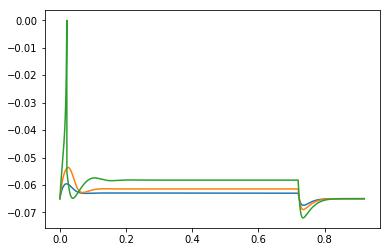

In [10]:
IinRange = [30,50,90]
tstop=720
print(RTN_burst)
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(RTN_burst)
print(RTN_burst)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

    print(model.results['sim_time'], 'simulation')    

9
11
19
20
mean simulation time: 0.0009829998016357422. Total time: 0.003931999206542969


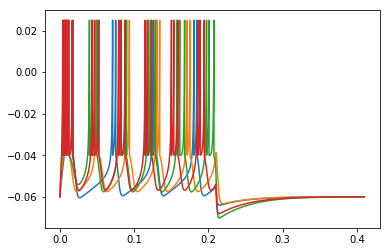

In [11]:
tstop = 210
IinRange = [290,370,500,550]
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(CH)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

7
0.19202113151550293 simulation
11
0.20689916610717773 simulation
19
0.20604872703552246 simulation
21
0.21396446228027344 simulation
mean simulation time: 0.0009829998016357422. Total time: 0.003931999206542969


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


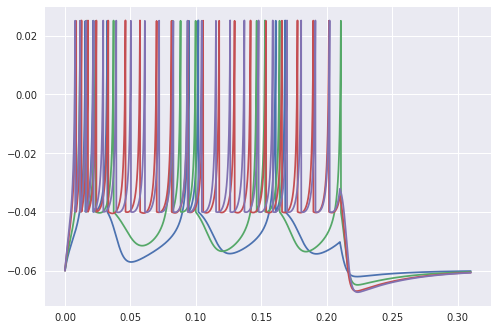

In [16]:
tstop = 210
IinRange = [290,370,500,550]

for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0*pq.ms
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = DURATION
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    model.set_attrs(CHN)
    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')    
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

6


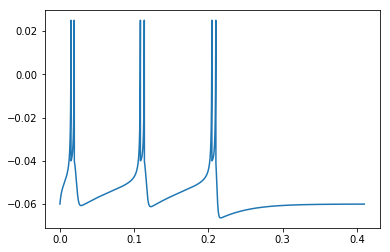

In [13]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 200*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0*pq.ms
DURATION = tstop*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = DURATION

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
#model.set_attrs(CHN)
model.set_attrs(CH)

model.inject_square_current(iparams)
print(model.get_spike_count())
plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())



Ignore the rest of cells


In [14]:

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)

import seaborn as sns
from neuronunit.optimization.data_transport_container import DataTC
import os
print(dir(model._backend))#.attrs)




params = {}
params['injected_square_current'] = {}
params['injected_square_current']['amplitude'] = 52*pq.pA
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
params['injected_square_current']['delay'] = DELAY
params['injected_square_current']['duration'] = DURATION

#first_two[0].observation['mean'] = 50*pq.pA

#first_two[1].observation['mean'] = 50*pq.ohm*1e6

#print(first_two)

score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score)
stuff = first_two[1].generate_prediction(model)
print(stuff)
print(model.get_spike_count(),'npsikes')
print(np.mean(model.get_membrane_potential()),'mean membrane potential')


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cell_name', '_local_run', 'attrs', 'backend', 'check_run_params', 'current_src_name', 'f', 'get_disk_cache', 'get_membrane_potential', 'get_memory_cache', 'init_backend', 'init_cache', 'init_disk_cache', 'init_memory_cache', 'inject_square_current', 'load_model', 'local_run', 'memory_cache', 'model', 'save_results', 'set_attrs', 'set_disk_cache', 'set_memory_cache', 'set_run_params', 'set_stop_time', 'sim_time', 'temp_attrs', 'use_disk_cache', 'use_memory_cache', 'vM']


NameError: name 'first_two' is not defined

In [ ]:
score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
print(model.get_spike_count())

In [ ]:
score = first_two[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:

model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))#,{'DTC':dtc}))
model.set_attrs(mparams)

prediction = all_tests[0].generate_prediction(model)
print(prediction)

prediction1 = all_tests[1].generate_prediction(model)
print(prediction1)

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
#passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
#firing_tests =  [ t for t in all_tests if str(t) not in passive ]

print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
        
    if cnt==0:
        model.rheobase = score.prediction['value']
        
        params = {}
        params['injected_square_current'] = {}
        params['injected_square_current']['amplitude'] = score.prediction['value']
        DELAY = 100.0*pq.ms
        DURATION = 1000.0*pq.ms
        params['injected_square_current']['delay'] = DELAY
        params['injected_square_current']['duration'] = DURATION
        model.params = params
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics

In [ ]:
import pandas as pd
import numpy as np
k_grid = np.logspace(-1.5,1,10)
#k_grid = np.logspace(-2,-1,10)
#k_grid = np.logspace(-1,1,10)


print(k_grid)

params = {}
params['a'] = 0.03
params['b'] = -2
params['C'] = 100
params['c'] = -50 
params['vr'] = -60
params['vt'] = -40
params['vPeak'] = 35
params['k'] = 0.7
params['d'] = 100
params['dt'] = 0.025
params['tMax'] = 1000.0;#   % max time [ms]
first_two = all_tests[0:2]
list_dics = []                                         
fig = plt.figure()
import copy
import pdb
tests_ = all_tests[0:2]
for k in k_grid:
    LEMS_MODEL_PATH = path_params['model_path']
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    params['k'] = k
    model.set_attrs(params)

    scores = []
    for index,t in enumerate(first_two):
        print("k=%.2g; Test=%s" % (k,t))
        score = t.judge(model, stop_on_error=True, deep_error=False)
        print(score.prediction,'rheobase why not?')
        scores.append(score)

    for s in scores:
        agreement = {}
        agreement['k'] = k
        print('bad k', k)
        agreement['test'] = s.test
        try:
            agreement['observation'] = s.observation['mean'].rescale(s.test.units)
            agreement['prediction'] = s.prediction['value'].rescale(s.test.units)
            agreement['agreement'] = float(agreement['observation'])/float(agreement['prediction'])
        except Exception as e:
            print('error score skip because %s' % e)
            agreement['agreement'] = None
        list_dics.append(agreement)




In [ ]:
#pd.set_option('display.precision', 3)
df = pd.DataFrame(list_dics)
dfg = df.reset_index(drop=True)
#dfg = dfg.dropna()
#dfg
#how='all'
#dfg = df.reset_index(drop=nan)


import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df
#ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
#plt.xscale('log')
#plt.yscale('log')

plt.xscale('log')
plt.yscale('log')

In [ ]:
list_dics

In [ ]:
print(k_grid)

In [ ]:
k_grid = np.logspace(-1,0,10)


In [ ]:
print(k_grid)

In [ ]:

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
#df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
plt.xscale('log')
plt.yscale('log')

In [ ]:
ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')


In [ ]:
# tests that do well, 4th last to second last.
# rheobase.
ft_ = all_tests[-4:-2]
ft_.insert(0,all_tests[0]) 
print(ft_)
free_params = ['k','b']
from neuronunit.optimization import optimization_management as om
ga_out, DO = om.run_ga(mp,3,ft_,free_params=free_params)


In [ ]:
type2007.keys()

In [ ]:
for k, v in type2007.items():
    print(v)

In [ ]:
param_dict